对应 `tf.keras` 的01~02章节

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=1, releaselevel='final', serial=0)
matplotlib 3.8.3
numpy 1.26.4
pandas 2.3.1
sklearn 1.7.1
torch 2.2.1+cpu
cpu


In [58]:
28*28

784

## 版本一：PIL 图像显示版（不使用 ToTensor()）

此版本：

图像为 PIL.Image.Image

适合使用 .size、.mode、getdata() 等函数

用于显示原始像素图像内容

<class 'PIL.Image.Image'>
图像大小: (28, 28)
图像模式: L
部分像素: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


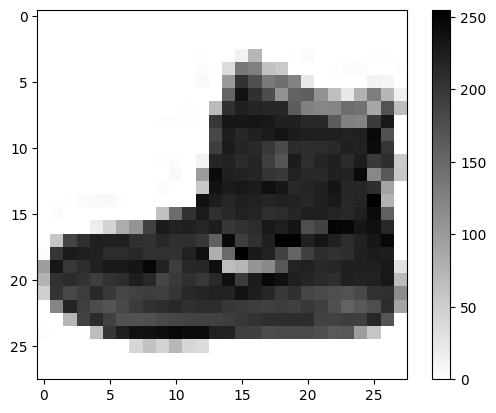

{}


In [75]:
# ---------------------- PIL版本 ----------------------
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

# 不使用 ToTensor，图像保留为 PIL.Image
transform_pil = transforms.Compose([
    # 注意：不要添加 ToTensor
])

train_ds_pil = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_pil  # 注意：不要添加 ToTensor, 否则会报错, 因为训练集没有标签, 无法使用 ToTensor, 所以这里只用 transform_pil, 而不用 ToTensor
)
test_ds_pil = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_pil  # 注意：不要添加 ToTensor, 否则会报错, 因为测试集没有标签, 无法使用 ToTensor, 所以这里只用 transform_pil, 而不用 ToTensor
)

# 查看图像类型和属性
img_pil, label_pil = train_ds_pil[0]
print(type(img_pil))  # <class 'PIL.Image.Image'>

def show_img_content_pil(img):
    print("图像大小:", img.size)
    print("图像模式:", img.mode)
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print("部分像素:", pixel_values[:50])  # 太多了只显示前50

def show_single_image_pil(img):
    plt.imshow(img, cmap="binary")  # 显示图片, cmap="binary" 显示黑白图片
    plt.colorbar()  # 显示颜色条
    plt.show()   # 显示图像

show_img_content_pil(img_pil)
show_single_image_pil(img_pil)

In [83]:
type(img_pil)#tensor中文是 张量,和numpy的ndarray类似

PIL.Image.Image

## 版本二：Tensor 图像显示版（使用 ToTensor()）
此版本：

图像为 torch.Tensor

可以使用 .shape、.mean() 等张量操作

用于模型训练/标准化等用途

<class 'torch.Tensor'>
图像形状: torch.Size([1, 28, 28])
像素范围: 0.0 ~ 1.0


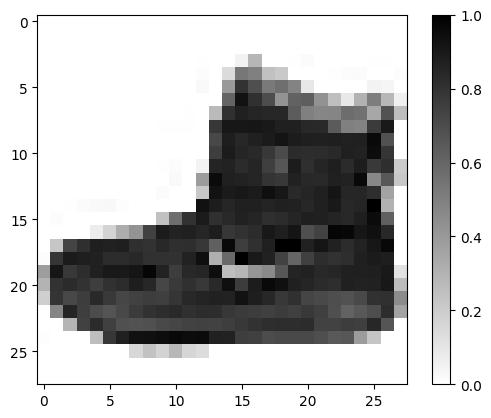

均值和方差: (tensor([0.2860]), tensor([0.3205]))


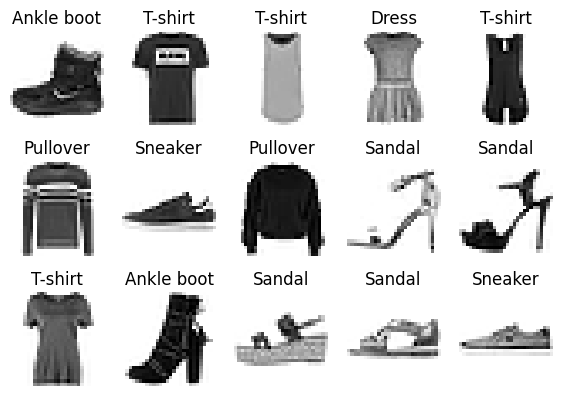

In [77]:
# ---------------------- Tensor版本 ----------------------
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor# 导入ToTensor，用于将PIL.Image转为Tensor，方便模型训练，标准化等用途，ToTensor()会将数据范围转为 [0,1]，并变成Tensor，所以不需要再使用 transforms.Normalize() 标准化
import matplotlib.pyplot as plt
import numpy as np
import torch

# 使用 ToTensor，图像变为 Tensor 格式
# 注意：如果使用 ToTensor，则不能使用 transforms.Normalize() 标准化，因为 ToTensor() 已经将数据范围转为 [0,1]
transform_tensor = transforms.Compose([  #
    transforms.ToTensor(),  # [0,1]，并变成Tensor
    #transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])

# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds_tensor = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_tensor
)
test_ds_tensor = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_tensor
)

img_tensor, label_tensor = train_ds_tensor[0]
print(type(img_tensor))  # <class 'torch.Tensor'>
print("图像形状:", img_tensor.shape)
print("像素范围:", img_tensor.min().item(), "~", img_tensor.max().item())

# 显示 Tensor 图像
def show_single_image_tensor(tensor_img):
    plt.imshow(tensor_img.squeeze(0), cmap="binary")  # squeeze通道表示，把通道数从1变为0，即把单通道的图片变为3通道的图片
    plt.colorbar()
    plt.show()

show_single_image_tensor(img_tensor)

# 计算均值和标准差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:  #_表示忽略标签,意思是只计算图片的均值和方差
        mean += img.mean(dim=(1, 2))
        #dim=(1, 2)表示计算每张图片的像素均值，dim=0表示计算所有图片的像素均值，dim=1表示计算每张图片的行均值，dim=2表示计算每张图片的列均值，dim=(0,1)表示计算所有图片的行均值，dim=(0,2)表示计算所有图片的列均值，dim=(1,2)表示计算所有图片的行列均值，dim=None表示计算所有图片的像素均值
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

print("均值和方差:", cal_mean_std(train_ds_tensor))

# 多图展示
#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']

def show_imgs_tensor(n_rows, n_cols, train_ds, class_names):#train_ds是数据集，class_names是类别名称，n_rows是打印行数，n_cols是打印列数
    assert n_rows * n_cols < len(train_ds) #确保打印的图片数量小于总样本数，这里是3*5，所以小于60，所以可以打印，如果大于60，则报错
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高 ，figsize设置图片大小，单位是英寸，默认是6.4，高6.4，所以宽高比为1.4，1.6，n_cols * 1.4作用是设置图片的宽度，n_rows * 1.6作用是设置图片的高度

    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col #计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)  #subplot(行数，列数，索引)，索引从1开始取出第index个样本
            img_arr, label = train_ds[index]  #取出第index个样本
            plt.imshow(img_arr.squeeze(0), cmap="binary", interpolation='nearest')#
            plt.axis('off')#去除坐标系，axis='off'，表示不显示坐标轴
            plt.title(class_names[label])#显示类别名称
    plt.show()

show_imgs_tensor(3, 5, train_ds_tensor, class_names)

# 加载器
train_loader = torch.utils.data.DataLoader(train_ds_tensor, batch_size=32, shuffle=True)  # 训练集加载器，batch_size=32表示每次取32张图片, shuffle=True表示打乱数据集
val_loader = torch.utils.data.DataLoader(test_ds_tensor, batch_size=32, shuffle=False)     # 测试集加载器

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [84]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [85]:
len(train_ds)

60000

In [86]:
type(train_ds[0])

tuple

In [91]:
img_tensor[0]  # 第0个样本的图像数据, 类型为tensor, 形状为[1, 28, 28], 值范围为[0, 1]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510, 0.2863, 0.0000,
         0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000

In [95]:
img_tensor.shape

torch.Size([1, 28, 28])

In [94]:
type(img_tensor)

torch.Tensor

In [92]:
type(img_tensor) #tensor中文是 张量,和numpy的ndarray类似

torch.Tensor

In [93]:
label

9

在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



## 定义模型

In [96]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10
        )

    def forward(self, x): # 前向计算
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()  # 实例化模型

In [97]:
# 看看网络结构,打印模型参数
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [19]:
784*300+300+300*100+100+100*10+10  # 计算模型参数数量

266610

In [98]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [99]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,requires_grad=True


[Parameter containing:
 tensor([[ 0.0344, -0.0355, -0.0094,  ...,  0.0187,  0.0333, -0.0065],
         [-0.0177,  0.0215,  0.0094,  ..., -0.0062, -0.0160,  0.0135],
         [-0.0182,  0.0091, -0.0331,  ...,  0.0226,  0.0218,  0.0151],
         ...,
         [ 0.0173,  0.0036, -0.0182,  ...,  0.0332, -0.0056, -0.0085],
         [ 0.0005, -0.0317, -0.0063,  ...,  0.0007,  0.0339, -0.0220],
         [-0.0239,  0.0195, -0.0132,  ...,  0.0205,  0.0134,  0.0046]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0028,  0.0185, -0.0134, -0.0219,  0.0067, -0.0251, -0.0344,  0.0081,
         -0.0285, -0.0194,  0.0222, -0.0259, -0.0012,  0.0333, -0.0201, -0.0070,
          0.0324,  0.0236, -0.0146, -0.0193,  0.0053, -0.0289,  0.0277, -0.0355,
          0.0341,  0.0177, -0.0326,  0.0313,  0.0308, -0.0108, -0.0282, -0.0289,
          0.0061, -0.0090,  0.0020,  0.0208,  0.0277,  0.0099,  0.0158,  0.0234,
          0.0220,  0.0089, -0.0306, -0.0304,  0.0187, -0.0303,  0.0138,  0.0270

In [22]:
# model.state_dict()  # 这种方法用于保存模型参数，看能看见参数属于模型的哪一部分

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [100]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() #内部先做softmax，然后计算交叉熵
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package,随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)#学习率0.001，动量0.9

In [101]:
from sklearn.metrics import accuracy_score

@torch.no_grad() # 装饰器，禁止反向传播，节省内存
def evaluating(model, dataloader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in dataloader:#10000/32=312
        datas = datas.to(device) # 转到GPU
        labels = labels.to(device) # 转到GPU
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 记录损失
        
        preds = logits.argmax(axis=-1)    # 验证集预测,argmax返回最大值索引
        # print(preds)
        pred_list.extend(preds.cpu().numpy().tolist())#将PyTorch张量转换为NumPy数组。只有当张量在CPU上时，这个转换才是合法的
        # print(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list) # 计算准确率
    return np.mean(loss_list), acc


In [102]:
1875*20 # 训练集样本数*每个样本的batch_size

37500

In [103]:
# 训练
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar: # 进度条 1875*20,60000/32=1875
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device) #datas尺寸是[batch_size,1,28,28]
                labels = labels.to(device) #labels尺寸是[batch_size]
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step() #梯度是计算并存储在模型参数的 .grad 属性中，优化器使用这些存储的梯度来更新模型参数

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值,一个数值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                }) # 记录训练集信息，每一步的损失，准确率，步数
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 进入评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 进入训练模式

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 20 #改为40
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [104]:
record["train"][-5:]

[{'loss': 0.4809505343437195, 'acc': 0.78125, 'step': 37495},
 {'loss': 0.3801080286502838, 'acc': 0.84375, 'step': 37496},
 {'loss': 0.22446662187576294, 'acc': 0.90625, 'step': 37497},
 {'loss': 0.17540034651756287, 'acc': 0.9375, 'step': 37498},
 {'loss': 0.28909844160079956, 'acc': 0.9375, 'step': 37499}]

In [105]:
record["val"][-5:]

[{'loss': 0.35770600850875384, 'acc': 0.872, 'step': 33000},
 {'loss': 0.3561726628710477, 'acc': 0.8711, 'step': 34000},
 {'loss': 0.35410533199152244, 'acc': 0.873, 'step': 35000},
 {'loss': 0.3570520611116871, 'acc': 0.8732, 'step': 36000},
 {'loss': 0.3520363474282594, 'acc': 0.8749, 'step': 37000}]

step
0        0.03125
1000     0.62500
2000     0.56250
3000     0.81250
4000     0.87500
5000     0.93750
6000     0.84375
7000     0.87500
8000     0.71875
9000     0.81250
10000    0.90625
11000    0.78125
12000    0.96875
13000    0.93750
14000    0.93750
15000    0.84375
16000    0.81250
17000    0.81250
18000    0.87500
19000    0.90625
20000    0.87500
21000    0.90625
22000    0.78125
23000    0.87500
24000    0.87500
25000    0.90625
26000    0.87500
27000    0.90625
28000    0.81250
29000    0.81250
30000    0.93750
31000    0.84375
32000    0.93750
33000    0.96875
34000    0.84375
35000    0.90625
36000    0.93750
37000    0.90625
Name: acc, dtype: float64
step
0        0.0993
1000     0.6841
2000     0.7606
3000     0.7934
4000     0.8079
5000     0.8166
6000     0.8210
7000     0.8286
8000     0.8334
9000     0.8357
10000    0.8375
11000    0.8431
12000    0.8466
13000    0.8425
14000    0.8434
15000    0.8517
16000    0.8576
17000    0.8555
18000    0.8460
19000    0.853

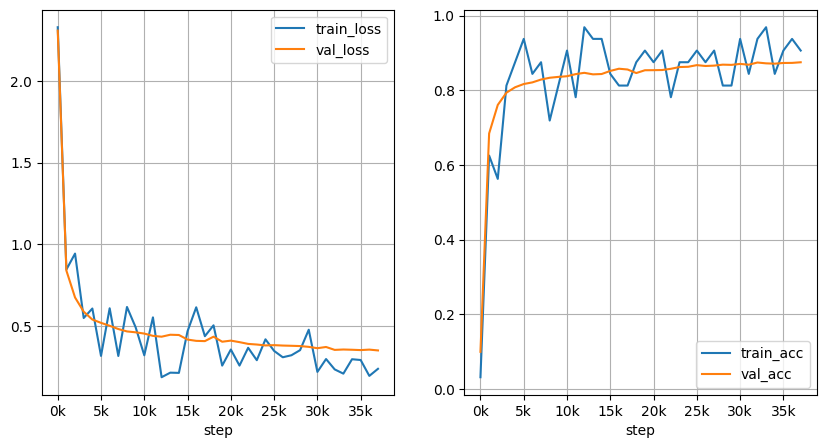

In [106]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1] # 最后一步的步数
    # print(train_df.columns)
    print(train_df['acc'])
    print(val_df['acc'])
    # plot
    fig_num = len(train_df.columns) # 画几张图,分别是损失和准确率
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        # print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid() # 显示网格
        axs[idx].legend() # 显示图例
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000)) # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000))) # 设置x轴标签
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record)  #横坐标是 steps

## 评估

In [107]:
# dataload for evaluating

model.eval() # 进入评估模式
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3593
accuracy: 0.8723


In [108]:
# 保存模型
torch.save(model.state_dict(), "fashion_mnist_classification.pth")